In [2]:
import kagglehub
import timm

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
torch.cuda.is_available()

True

In [4]:
config = {
    'batch_size': 256,
    'learning_rate': 0.003,
    'epochs': 10,
    'device': 'cuda',
    'data_dir': 'data/',
    'log_dir': 'runs/experiment1'
}

In [6]:
# if not os.path.exists('aux/intel-imgs'):
#     !wget --no-check-certificate \
#     https://www.kaggle.com/api/v1/datasets/download/puneet6060/intel-image-classification -O intel-imgs.zip
#     !unzip -qq intel-imgs.zip

In [7]:
trnsfrms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

In [8]:
!ls

intel-imgs.zip		  onstart.sh  seg_pred	seg_train
mobilenet-trained-6cl.pt  ports.log   seg_test	wip-0.2.ipynb


In [9]:
train_dataset = torchvision.datasets.ImageFolder('seg_train/seg_train', 
                                                 transform=trnsfrms)
valid_dataset = torchvision.datasets.ImageFolder('seg_test/seg_test', 
                                                 transform=trnsfrms)

In [10]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [11]:
model = timm.create_model('swin_base_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)

In [18]:
for p in model.parameters():
    print(p.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
model.head.fc = nn.Linear(1024, 6)

In [15]:
model.head.fc.weight.requires_grad = True
model.head.fc.bias.requires_grad = True

In [16]:
optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [17]:
DEVICE='cuda'

In [19]:
def plot_history(history, grid=True):
    fig, ax = plt.subplots(1,2, figsize=(14,5))

    ax[0].plot(history['train_losses'], label='train loss')
    ax[0].plot(history['valid_losses'], label='valid loss')
    ax[0].set_title(f'Loss on epoch {len(history["train_losses"])}')
    ax[0].grid(grid)
    ax[0].set_ylim((0, max(history['train_losses'] + history['valid_losses']) + .1))
    ax[0].legend()

    ax[1].plot(history['train_accs'], label='train acc')
    ax[1].plot(history['valid_accs'], label='valid acc')
    ax[1].set_title(f'Accuracy on epoch {len(history["train_losses"])}')
    ax[1].grid(grid)
    ax[1].set_ylim((0, 1))
    ax[1].legend()

    plt.show()

In [20]:
def fit_model(
        model: nn.Module,
        epochs: int,
        optimizer: torch.optim.Optimizer,
        criterion: torch.nn.modules.loss,
        history=None
    ):
    history = history or {
        'train_accs': [],
        'train_losses': [],
        'valid_accs': [],
        'valid_losses': [],
    }

    for epoch in range(1, epochs + 1):
        model.train()
        batch_losses = []
        batch_accs = []

        for samples, labels in train_loader:
            samples = samples.to(DEVICE)
            labels = labels.to(DEVICE)

            y_pred = model(samples)
            loss = criterion(y_pred, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        train_loss = np.mean(batch_losses)
        train_acc  = np.mean(batch_accs)
        history['train_losses'].append(train_loss)
        history['train_accs'].append(train_acc)

        model.eval()
        batch_losses = []
        batch_accs = []
        with torch.no_grad():
            for samples, labels in valid_loader:
                samples = samples.to(DEVICE)
                labels = labels.to(DEVICE)
                y_pred = model(samples)
                loss = criterion(y_pred, labels)
                batch_losses.append(loss.item())
                batch_accs.append((y_pred.argmax(dim=1) == labels).float().mean().item())

        valid_loss = np.mean(batch_losses)
        valid_acc  = np.mean(batch_accs)
        history['valid_losses'].append(valid_loss)
        history['valid_accs'].append(valid_acc)

        print(
            f"Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}"
        )

    plot_history(history)
    return history

Epoch 1/10 | Train Loss: 0.2877, Train Acc: 0.9188 | Val Loss: 0.1811, Val Acc: 0.9350
Epoch 2/10 | Train Loss: 0.1784, Train Acc: 0.9361 | Val Loss: 0.1596, Val Acc: 0.9441
Epoch 3/10 | Train Loss: 0.1605, Train Acc: 0.9439 | Val Loss: 0.1567, Val Acc: 0.9422
Epoch 4/10 | Train Loss: 0.1544, Train Acc: 0.9447 | Val Loss: 0.1571, Val Acc: 0.9464
Epoch 5/10 | Train Loss: 0.1500, Train Acc: 0.9467 | Val Loss: 0.1613, Val Acc: 0.9410
Epoch 6/10 | Train Loss: 0.1428, Train Acc: 0.9499 | Val Loss: 0.1545, Val Acc: 0.9435
Epoch 7/10 | Train Loss: 0.1406, Train Acc: 0.9488 | Val Loss: 0.1550, Val Acc: 0.9416
Epoch 8/10 | Train Loss: 0.1394, Train Acc: 0.9491 | Val Loss: 0.1497, Val Acc: 0.9425
Epoch 9/10 | Train Loss: 0.1329, Train Acc: 0.9519 | Val Loss: 0.1441, Val Acc: 0.9453
Epoch 10/10 | Train Loss: 0.1305, Train Acc: 0.9526 | Val Loss: 0.1502, Val Acc: 0.9465


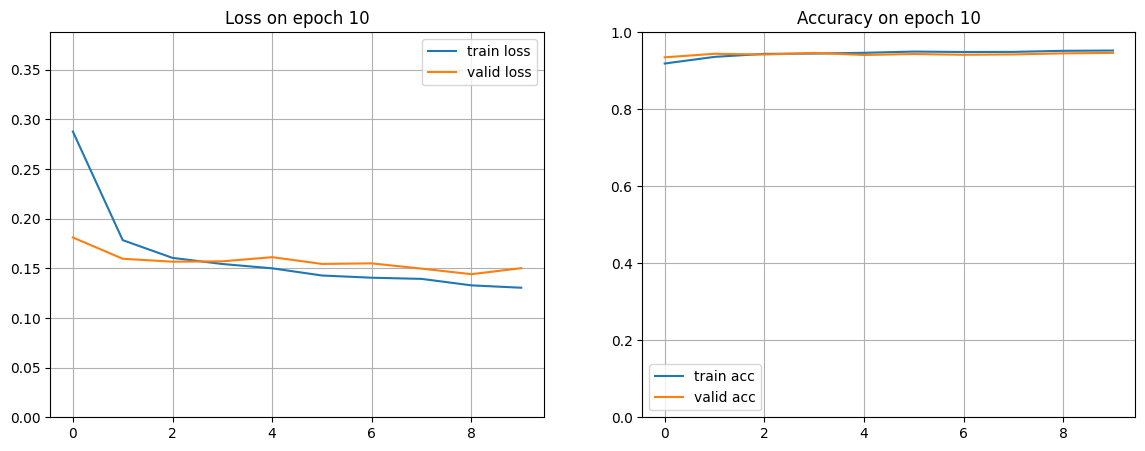

In [21]:
model.to(DEVICE)

history = fit_model(model, config['epochs'], optimizer, criterion)

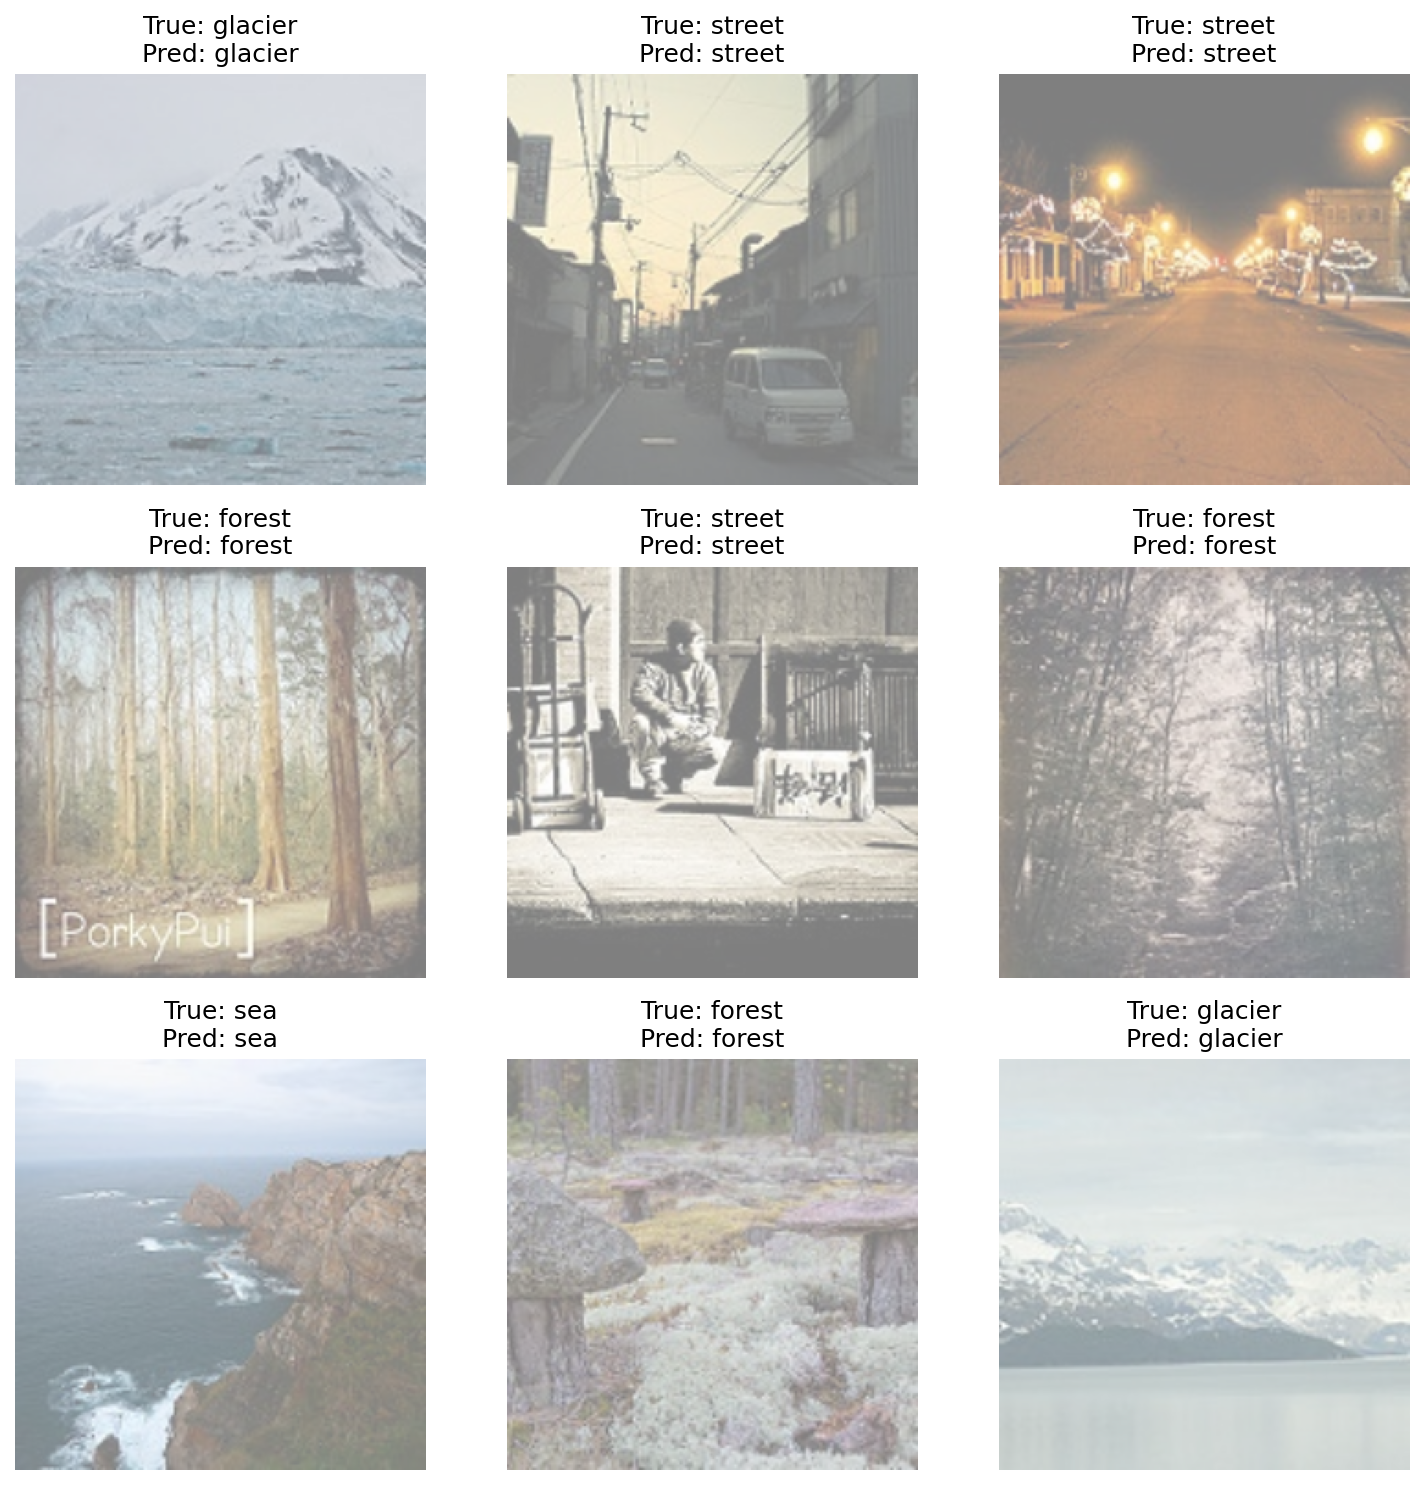

In [22]:
model.to(DEVICE)
model.eval()  # Set to evaluation mode

# CIFAR-10 class names
class_names = valid_dataset.classes  # ['airplane', 'automobile', 'bird', 'cat', ... ]

# Select 9 random images
indices = torch.randperm(len(valid_dataset))[:9]
samples, targets = zip(*[valid_dataset[i] for i in indices])

# Stack tensors and move to DEVICE
samples = torch.stack(samples).to(DEVICE)
targets = torch.tensor(targets)

# Get model predictions
with torch.no_grad():
    predictions = model(samples)
    predicted_classes = predictions.argmax(dim=1).cpu()  # Move to CPU for display

# Create 3×3 grid
fig, axes = plt.subplots(3, 3, figsize=(10, 10), dpi=150)
for i, ax in enumerate(axes.flat):
    img = samples[i].cpu().permute(1, 2, 0) * 0.5 + 0.5  # Unnormalize
    ax.imshow(img.numpy())
    ax.set_title(f"True: {class_names[targets[i]]}\nPred: {class_names[predicted_classes[i]]}")
    ax.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [23]:
torch.save(model, "mobilenet-trained-6cl-95acc.pt")
torch.save(model.state_dict(), "mobilenet-trained-6cl-95acc-dict.pt")